log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)# Proof that neural nets can compute any function


In the mathematical theory of artificial neural networks, universal approximation theorems are results that establish the density of an algorithmically generated class of functions within a given function space of interest.

To test this theory lets generate test data with some random function which we define.

Lets say that the function,

f(x) = $sin((1+x)^2)$

In [61]:

import datetime
# Build a Keras Dense Model.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp


In [105]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [106]:
# All imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from sklearn.preprocessing import StandardScaler

In [107]:
# let X be the ndarrays from numy
def random_function(x):
    return sin_function(np.power((1+x), 2))

In [108]:
def sin_function(x):
    return np.sin(x)

In [109]:
def generate_x(count=20, step=0.5):
    return np.random.randn(count)
    #return np.arange(0, count, step=0.5)

In [110]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [111]:
# lets test this function
x = generate_x(20)
y = random_function(x)

In [112]:
x

array([-0.51912012, -0.79812256,  0.50656262,  0.08980596, -0.6250209 ,
        0.89520874, -0.77191979, -0.61505218, -1.41124235,  0.54614981,
       -0.03196715, -0.37795925,  1.89170091, -0.92529071,  1.10075795,
       -0.206529  ,  0.79223447,  1.35484792,  1.09726734,  1.83385854])

In [113]:
y

array([ 0.22919   ,  0.04074322,  0.7655281 ,  0.92750311,  0.14014645,
       -0.4351668 ,  0.05199712,  0.1476431 ,  0.16831523,  0.68237993,
        0.80583697,  0.37735151,  0.87374221,  0.00558145, -0.95557112,
        0.58881845, -0.07045334, -0.67271832, -0.95114936,  0.98441637])

In [114]:
def plot_fig(x, y):
    plt.figure(figsize=(10,5))
    plt.scatter(range(0,len(x)), y, s=25)
    plt.show()

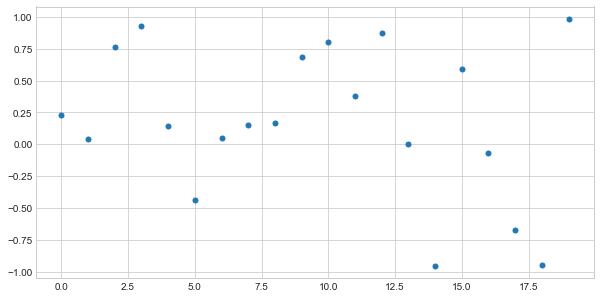

In [115]:
plot_fig(x, y)

In [116]:
def load_data():
    train_x = generate_x(100)
    train_y = random_function(train_x)
    val_x = generate_x(50)
    val_y = random_function(val_x)
    test_x = generate_x(30)
    test_y = random_function(test_x)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

In [117]:
train_x, train_y, val_x, val_y, test_x, test_y= load_data()

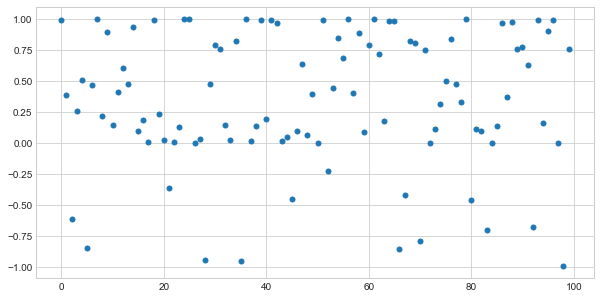

In [118]:
plot_fig(train_x, train_y)

In [119]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([50, 100]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'mean_squared_error'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='mean_squared_error')],
  )

In [120]:
def train_test_model(hparams):
    model = keras.Sequential(name="my_sequential")
    model.add(layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
    model.add(layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='mean_squared_error'
    )

    model.fit(train_x, train_y, epochs=1) # Run with 1 epoch to speed things up for demo purposes
    accuracy = model.evaluate(test_x, test_y)
    return accuracy

In [121]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [122]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1


--- Starting trial: run-0
{'num_units': 50, 'dropout': 0.1, 'optimizer': 'adam'}
1/1 [==============================] - 0s 1ms/step - loss: 0.5691
--- Starting trial: run-1
{'num_units': 50, 'dropout': 0.1, 'optimizer': 'sgd'}
1/1 [==============================] - 0s 1ms/step - loss: 0.5861
--- Starting trial: run-2
{'num_units': 50, 'dropout': 0.2, 'optimizer': 'adam'}
1/1 [==============================] - 0s 868us/step - loss: 0.4982
--- Starting trial: run-3
{'num_units': 50, 'dropout': 0.2, 'optimizer': 'sgd'}
1/1 [==============================] - 0s 778us/step - loss: 0.4637
--- Starting trial: run-4
{'num_units': 100, 'dropout': 0.1, 'optimizer': 'adam'}
1/1 [==============================] - 0s 914us/step - loss: 0.5274
--- Starting trial: run-5
{'num_units': 100, 'dropout': 0.1, 'optimizer': 'sgd'}
1/1 [==============================] - 0s 835us/step - loss: 0.5179
--- Starting trial: run-6
{'num_units': 100, 'dropout': 0.2, 'optimizer': 'adam'}
1/1 [========================

In [ ]:
!tensorboard --logdir logs/hparam_tuning/

In [79]:
def plot_pred(test_x, test_y, prediction):
    plt.figure(figsize=(10,5))
    plt.title("Predictions (red) and acutal (blue).")
    r = range(0, len(test_x))
    plt.scatter(r, test_y, s=25, color="blue")
    plt.scatter(r, prediction, s=25, color="red")
    plt.show()

In [80]:
prediction = model.predict(test_x, batch_size=10, verbose=1)

3/3 [==============================] - 0s 849us/step


In [81]:
model.save("model.h5")

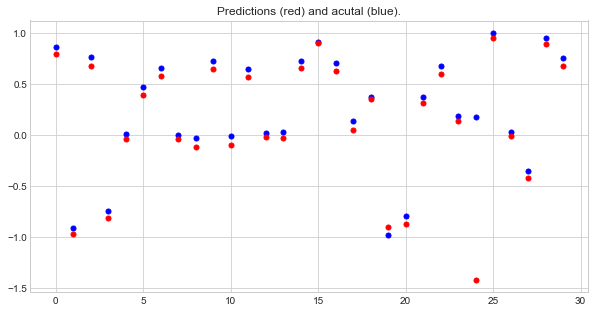

In [82]:
plot_pred(test_x, test_y, prediction)

In [83]:
from sklearn.metrics import r2_score
def accu(test_y, pred):
    return r2_score(test_y, pred)*100

In [84]:
accu(prediction, test_y)

76.96279017463516